In [691]:
%pip install pandas numpy matplotlib scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, math, random, time

Note: you may need to restart the kernel to use updated packages.


### Provide sensor data recording to run the processing/analysis on

In [692]:
SENSOR_DATA = 'recordings/up_down3.csv'
ALGORITHM_DATA = SENSOR_DATA.replace('recordings/', 'analysis/').replace('.csv', '_algo.csv')
ANGLES_DATA = SENSOR_DATA.replace('recordings/', 'analysis/').replace('.csv', '_angles.csv')
STEPS_DATA = SENSOR_DATA.replace('recordings/', 'analysis/').replace('.csv', '_steps.csv')

### Cut off debug data from flashing if there's any left

In [693]:
HEADERS = "time,gyro.x,gyro.y,gyro.z,accel.x,accel.y,accel.z"
lines = []
cutting = False
with open(SENSOR_DATA, 'r') as file:
    found_start = False
    for (i, line) in enumerate(file.readlines()):
        if not found_start and HEADERS in line:
            if i == 0:
                break
            found_start = True
            cutting = True
        if found_start:
            lines.append(line)
if cutting:
    with open(SENSOR_DATA, 'w') as file:
        file.writelines(lines[:-1])

### Run the sensor processing code

In [694]:
result = os.system(f'cargo run --release -- {SENSOR_DATA}')
if result != 0:
    raise Exception('Failed to compile sensor data')

   Compiling test-processing v0.1.0 (/home/matt/Projects/2024/gait-analyzer/test-processing)
  --> src/main.rs:23:13
   |
23 |     let mut step_detection = StepDetection::new();
   |             ^^^^^^^^^^^^^^ help: if this is intentional, prefix it with an underscore: `_step_detection`
   |
   = note: `#[warn(unused_variables)]` on by default

  --> src/main.rs:23:9
   |
23 |     let mut step_detection = StepDetection::new();
   |         ----^^^^^^^^^^^^^^
   |         |
   |         help: remove this `mut`
   |
   = note: `#[warn(unused_mut)]` on by default

    Finished `release` profile [optimized] target(s) in 0.40s
     Running `target/release/test-processing recordings/up_down3.csv`


### Load sensor data

In [695]:
steps = pd.read_csv(SENSOR_DATA)
# Convert ESP32 system time to local time so the graphs make more sense.
now = time.time()
steps['t'] = pd.to_datetime((steps['time'] / 1_000_000_000.0) + now, unit='s')
steps.set_index(steps['t'], inplace=True)
steps.drop(columns=['t'], inplace=True)
steps

,time,gyro.x,gyro.y,gyro.z,accel.x,accel.y,accel.z
t,,,,,,,
2024-11-28 00:05:10.257384300,2880417970000,0.001332,0.000000,0.000400,-0.143652,-0.556652,9.815030
2024-11-28 00:05:10.263752460,2880424338000,0.001466,0.000000,0.000266,-0.134075,-0.561440,9.816227
2024-11-28 00:05:10.270840406,2880431426000,0.001599,-0.000133,0.000400,-0.137667,-0.545878,9.810242
2024-11-28 00:05:10.279090405,2880439676000,0.001732,-0.000133,0.000666,-0.161609,-0.548272,9.801862
2024-11-28 00:05:10.286141396,2880446727000,0.001599,-0.000266,0.000666,-0.161609,-0.545878,9.791088
...,...,...,...,...,...,...,...
2024-11-28 00:05:27.624943256,2897785529000,0.000933,-0.000400,0.000133,-0.112527,-1.007959,9.765948
2024-11-28 00:05:27.632281303,2897792867000,0.001199,0.000533,0.000133,-0.124498,-0.997185,9.785102
2024-11-28 00:05:27.640274286,2897800860000,0.001199,0.000666,0.000133,-0.132878,-1.007959,9.792285


### Load algorithm debug data

In [696]:
algo = pd.read_csv(ALGORITHM_DATA)
# Convert ESP32 system time to local time so the graphs make more sense.
algo['t'] = pd.to_datetime((algo['time'] / 1_000_000_000.0) + now, unit='s')
algo.set_index(algo['t'], inplace=True)
algo.drop(columns=['t'], inplace=True)
algo.head()

,time,orientation.w,orientation.x,orientation.y,orientation.z,velocity.x,velocity.y,velocity.z,position.x,position.y,...,world_acc.y,world_acc.z,gyro_orientation.w,gyro_orientation.x,gyro_orientation.y,gyro_orientation.z,accel_orientation.w,accel_orientation.x,accel_orientation.y,accel_orientation.z
t,,,,,,,,,,,,,,,,,,,,,
2024-11-28 00:05:10.257501364,2880418086912,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000
2024-11-28 00:05:10.263792753,2880424378368,0.999999,-0.001424,0.000341,0.000011,-0.000801,-0.003356,0.000071,-0.000005,-0.000021,...,-0.533489,0.011225,1.000000,0.000005,0.000000,8.382189e-07,0.999569,-0.028562,0.006815,0.000195
2024-11-28 00:05:10.270870686,2880431456256,0.999996,-0.002737,0.000673,0.000021,-0.001682,-0.006839,0.000117,-0.000017,-0.000070,...,-0.492180,0.006608,0.999999,-0.001418,0.000340,1.194643e-05,0.999589,-0.027789,0.007002,0.000195
2024-11-28 00:05:10.278997183,2880439582720,0.999992,-0.003990,0.001051,0.000034,-0.002545,-0.009593,0.000103,-0.000038,-0.000147,...,-0.470047,-0.000408,0.999996,-0.002730,0.000673,2.378649e-05,0.999576,-0.027934,0.008227,0.000230
2024-11-28 00:05:10.286074877,2880446660608,0.999986,-0.005177,0.001409,0.000046,-0.003144,-0.011465,0.000029,-0.000060,-0.000229,...,-0.444479,-0.010017,0.999992,-0.003984,0.001050,3.644840e-05,0.999578,-0.027843,0.008236,0.000229


### Preview raw sensor data

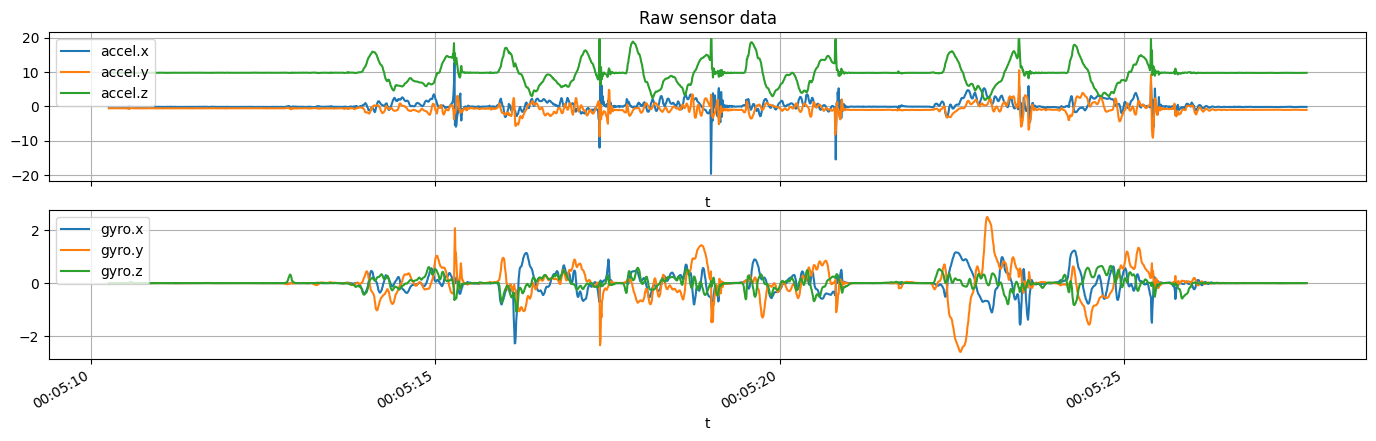

In [697]:
fig, (ax1, ax2) = plt.subplots(2, 1)

steps['accel.x'].plot(ax=ax1)
steps['accel.y'].plot(ax=ax1)
steps['accel.z'].plot(ax=ax1)
ax1.xaxis.set_ticklabels([])
ax1.legend(loc='upper left')
ax1.grid()

steps['gyro.x'].plot(ax=ax2)
steps['gyro.y'].plot(ax=ax2)
steps['gyro.z'].plot(ax=ax2)
ax2.legend(loc='upper left')
ax2.grid()

ax1.set_title('Raw sensor data')
fig.set_figwidth(17)

### Gravity vector length

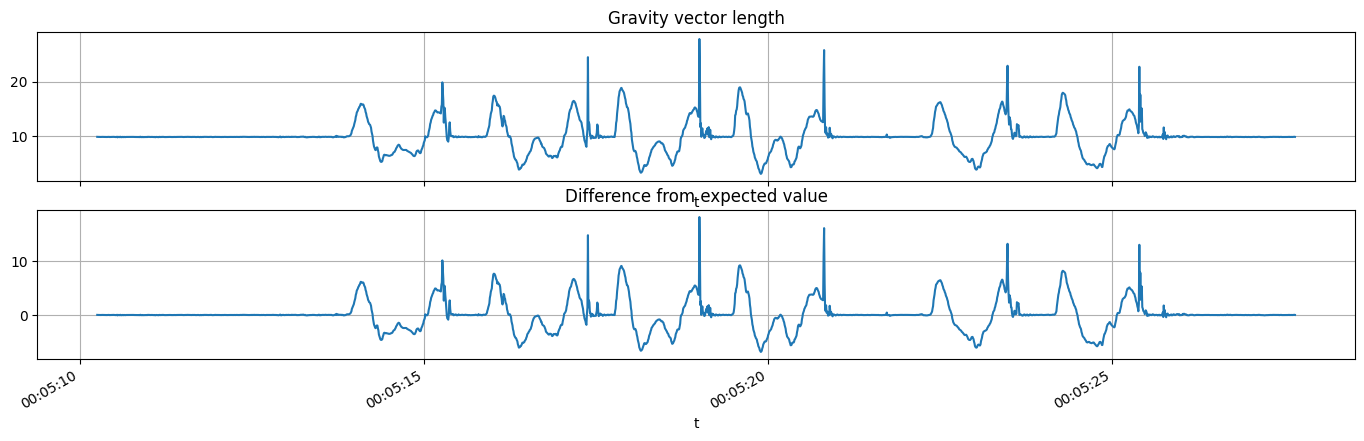

In [698]:
fig, (ax1, ax2) = plt.subplots(2, 1)

steps['accel._length'] = np.sqrt(steps['accel.x'] ** 2 + steps['accel.y'] ** 2 + steps['accel.z'] ** 2)
steps['accel._length'].plot(ax=ax1)
ax1.grid()
ax1.set_title('Gravity vector length')
ax1.xaxis.set_ticklabels([])

steps['gravity_delta'] = steps['accel._length'] - 9.80665
steps['gravity_delta'].plot(ax=ax2)
ax2.grid()
ax2.set_title('Difference from expected value')

fig.set_figwidth(17)

### Preview computed position, velocity, acceleration

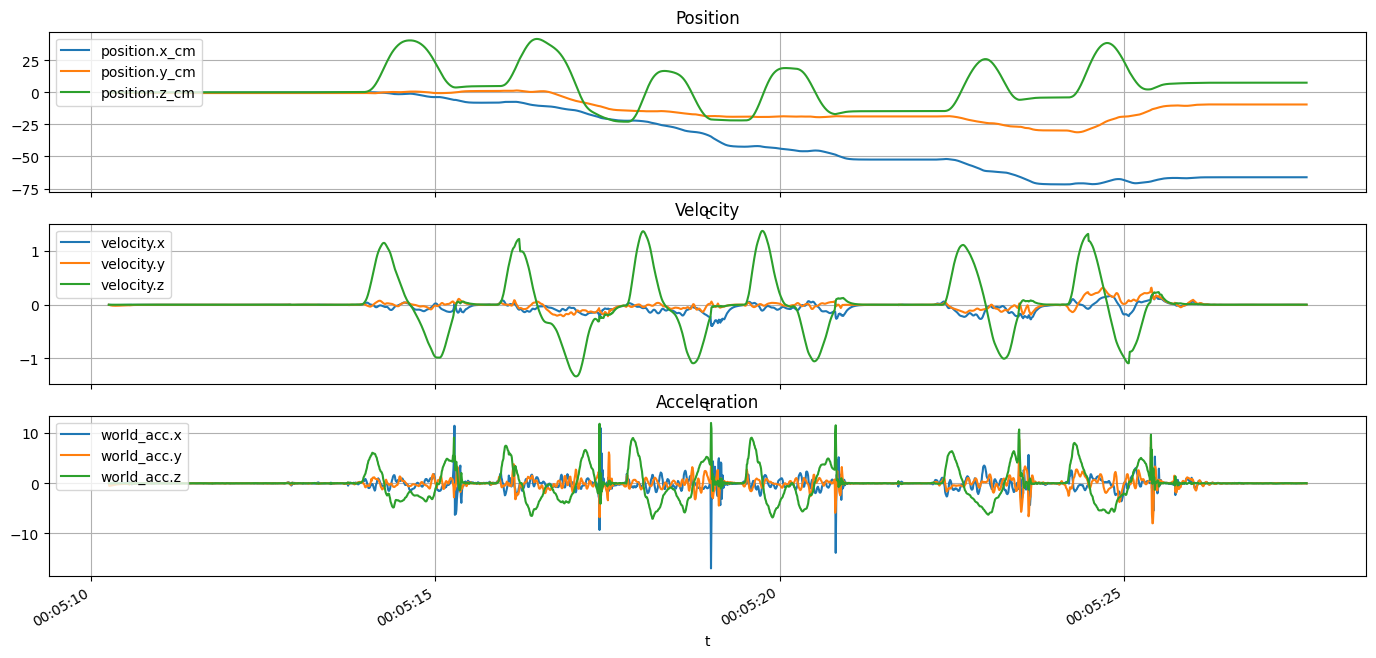

In [699]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

algo['position.x_cm'] = algo['position.x'] * 100
algo['position.y_cm'] = algo['position.y'] * 100
algo['position.z_cm'] = algo['position.z'] * 100

algo['position.x_cm'].plot(ax=ax1)
algo['position.y_cm'].plot(ax=ax1)
algo['position.z_cm'].plot(ax=ax1)
ax1.legend(loc='upper left')
ax1.grid()
ax1.set_title('Position')
ax1.xaxis.set_ticklabels([])

algo['velocity.x'].plot(ax=ax2)
algo['velocity.y'].plot(ax=ax2)
algo['velocity.z'].plot(ax=ax2)
ax2.legend(loc='upper left')
ax2.grid()
ax2.set_title('Velocity')
ax2.xaxis.set_ticklabels([])

algo['world_acc.x'].plot(ax=ax3)
algo['world_acc.y'].plot(ax=ax3)
algo['world_acc.z'].plot(ax=ax3)
ax3.legend(loc='upper left')

ax3.grid()
ax3.set_title('Acceleration')

fig.set_figwidth(17)
fig.set_figheight(8)

### Load Euler angles

In [700]:
angles = pd.read_csv(ANGLES_DATA)
# Convert ESP32 system time to local time so the graphs make more sense.
angles['t'] = pd.to_datetime((angles['time'] / 1_000_000_000.0) + now, unit='s')
angles.set_index(angles['t'], inplace=True)
angles.drop(columns=['t'], inplace=True)
angles.head()

,time,fusion.yaw,fusion.pitch,fusion.roll,gyro.yaw,gyro.pitch,gyro.roll,accel.yaw,accel.pitch,accel.roll,gyro.x,gyro.y,gyro.z,gyro.w
t,,,,,,,,,,,,,,
2024-11-28 00:05:10.257501364,2880418086912,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000
2024-11-28 00:05:10.263792753,2880424378368,0.001151,0.039049,-0.163150,0.000096,-4.428230e-10,0.000528,-1.667682e-09,0.781259,-3.273505,0.000005,0.000000,8.382189e-07,1.000000
2024-11-28 00:05:10.270870686,2880431456256,0.002205,0.077173,-0.313601,0.001314,3.899562e-02,-0.162502,-1.667690e-09,0.802737,-3.184873,-0.001418,0.000340,1.194643e-05,0.999999
2024-11-28 00:05:10.278997183,2880439582720,0.003426,0.120403,-0.457211,0.002515,7.711238e-02,-0.312794,0.000000e+00,0.943109,-3.201537,-0.002730,0.000673,2.378649e-05,0.999996
2024-11-28 00:05:10.286074877,2880446660608,0.004446,0.161484,-0.593270,0.003697,1.202972e-01,-0.456563,0.000000e+00,0.944148,-3.191062,-0.003984,0.001050,3.644840e-05,0.999992


### Compare orientations

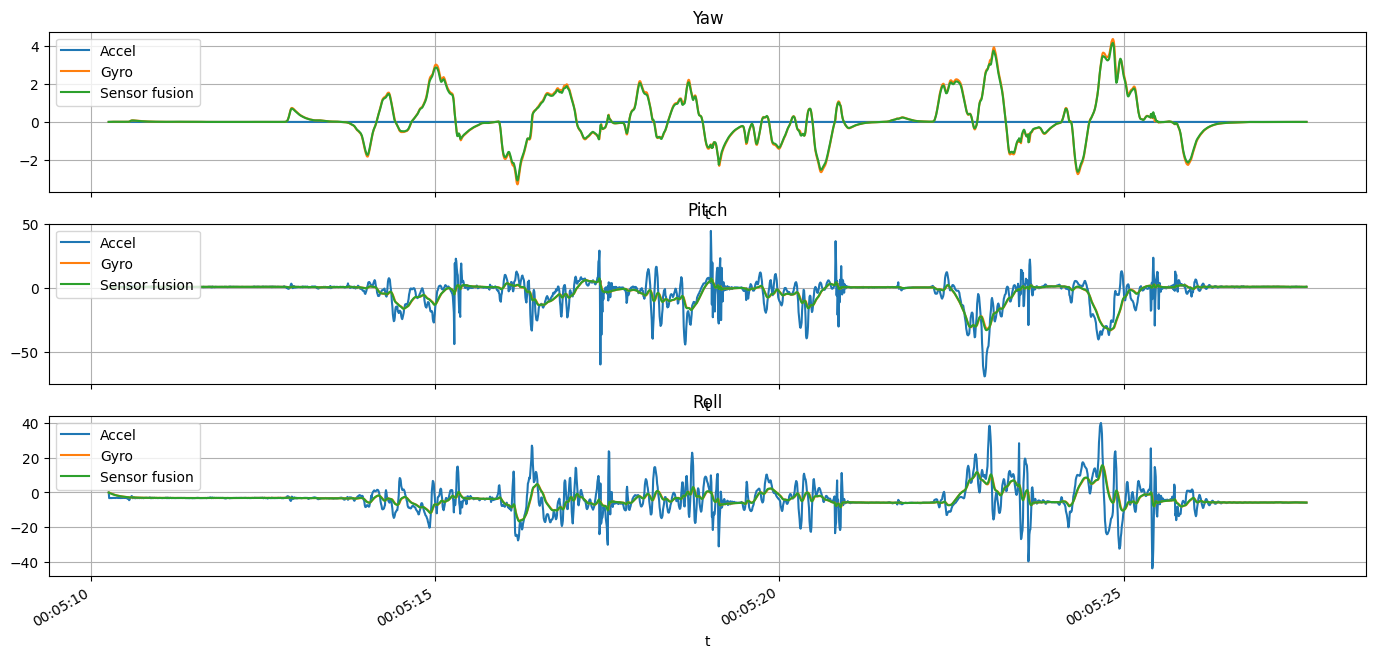

In [701]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

angles['accel.yaw'].plot(ax=ax1, label='Accel')
angles['gyro.yaw'].plot(ax=ax1, label='Gyro')
angles['fusion.yaw'].plot(ax=ax1, label='Sensor fusion')
ax1.legend(loc='upper left')
ax1.grid()
ax1.set_title('Yaw')
ax1.xaxis.set_ticklabels([])

angles['accel.pitch'].plot(ax=ax2, label='Accel')
angles['gyro.pitch'].plot(ax=ax2, label='Gyro')
angles['fusion.pitch'].plot(ax=ax2, label='Sensor fusion')
ax2.legend(loc='upper left')
ax2.grid()
ax2.set_title('Pitch')
ax2.xaxis.set_ticklabels([])

angles['accel.roll'].plot(ax=ax3, label='Accel')
angles['gyro.roll'].plot(ax=ax3, label='Gyro')
angles['fusion.roll'].plot(ax=ax3, label='Sensor fusion')
ax3.legend(loc='upper left')
ax3.grid()
ax3.set_title('Roll')

fig.set_figwidth(17)
fig.set_figheight(8)

### Review quaternion values from gyro

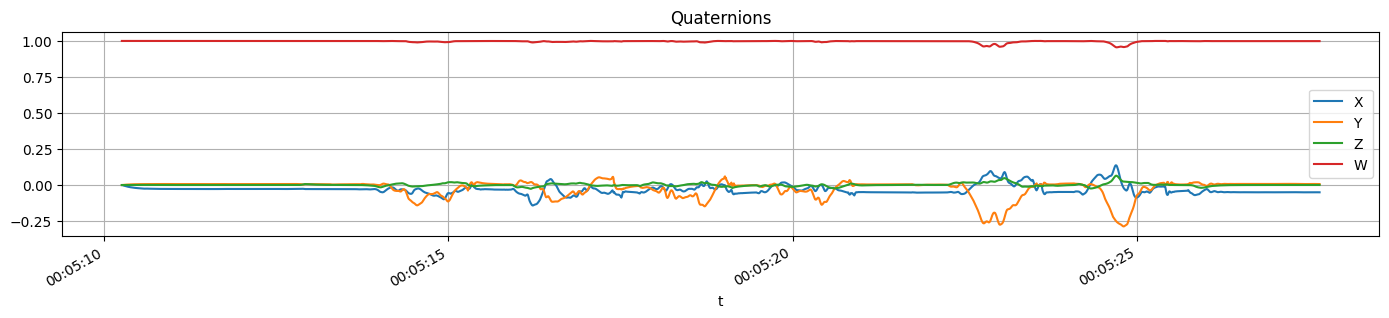

In [702]:
fig, ax1 = plt.subplots(1, 1)

angles['gyro.x'].plot(ax=ax1, label='X')
angles['gyro.y'].plot(ax=ax1, label='Y')
angles['gyro.z'].plot(ax=ax1, label='Z')
angles['gyro.w'].plot(ax=ax1, label='W')
ax1.grid()
ax1.set_title('Quaternions')
ax1.legend()

fig.set_figwidth(17)
fig.set_figheight(3)

### Packets per second

<Axes: xlabel='t'>

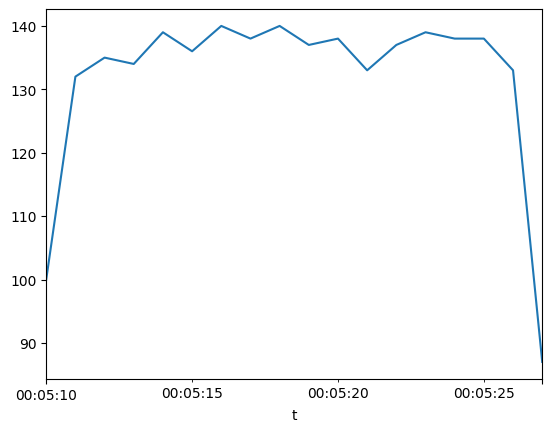

In [703]:
packets = steps.resample('1s').count()
packets.drop(columns=['gyro.x','gyro.y'], inplace=True)
packets.rename(columns={'time': 'packets/s'}, inplace=True)
packets['packets/s'].plot()

### Analyze the detected steps

In [704]:
steps = pd.read_csv(STEPS_DATA)
# Convert ESP32 system time to local time so the graphs make more sense.
steps['start'] = pd.to_datetime((steps['start'] / 1_000_000_000.0) + now, unit='s')
steps['peak'] = pd.to_datetime((steps['peak'] / 1_000_000_000.0) + now, unit='s')
steps['finished'] = pd.to_datetime((steps['finished'] / 1_000_000_000.0) + now, unit='s')
steps

,start,peak,finished,peak.x,peak.y,peak.z


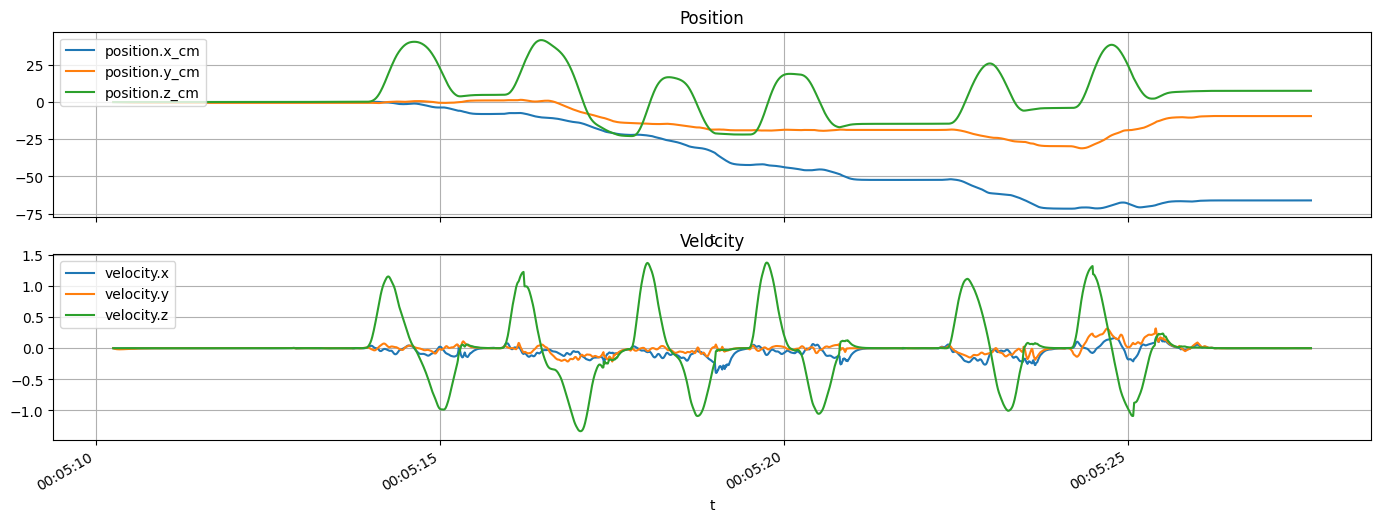

In [705]:
fig, (ax1, ax2) = plt.subplots(2, 1)

algo['position.x_cm'] = algo['position.x'] * 100
algo['position.y_cm'] = algo['position.y'] * 100
algo['position.z_cm'] = algo['position.z'] * 100

algo['position.x_cm'].plot(ax=ax1)
algo['position.y_cm'].plot(ax=ax1)
algo['position.z_cm'].plot(ax=ax1)
ax1.legend(loc='upper left')
ax1.grid()
ax1.set_title('Position')
ax1.xaxis.set_ticklabels([])

algo['velocity.x'].plot(ax=ax2)
algo['velocity.y'].plot(ax=ax2)
algo['velocity.z'].plot(ax=ax2)
ax2.legend(loc='upper left')
ax2.grid()
ax2.set_title('Velocity')

for ax in [ax1, ax2]:
    for (i, step) in steps.iterrows():
        ax.axvspan(
            step['start'],
            step['finished'],
            color='blue',
            alpha=0.15
        )

fig.set_figwidth(17)
fig.set_figheight(6)